### Binary Classification
https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/binary_classification.ipynb

Question: Are houses in this neighborhood higher than a certain Price?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

2023-09-21 20:20:49.023486: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 20:20:49.781380: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 20:20:49.789021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 20:20:56.183556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_df = pd.read_csv('dataset/california_housing_train.csv')
test_df = pd.read_csv('dataset/california_housing_test.csv')

In [3]:
train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3021,-117.80,34.05,5.0,4536.0,1178.0,2485.0,909.0,4.1118,125900.0
15131,-122.26,37.84,52.0,950.0,202.0,467.0,198.0,3.9643,188800.0
13456,-121.95,37.34,25.0,5236.0,1320.0,2529.0,1213.0,3.1702,256100.0
8759,-118.60,34.07,16.0,319.0,59.0,149.0,64.0,4.6250,433300.0
397,-116.94,32.82,35.0,1737.0,285.0,826.0,294.0,3.2411,159200.0


#### Normalize Features using Z-Score
z-score(value) = (value - mean) / std

In [4]:
train_df_means = train_df.mean()
train_df_stds = train_df.std()

train_df_norm = (train_df - train_df_means) / train_df_stds # vectorization
test_df_norm = (test_df - train_df_means) / train_df_stds
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3021,0.878784,-0.737002,-1.874114,0.868065,1.515042,0.919478,1.060484,0.119603,-0.701830
15131,-1.345470,1.036230,1.859916,-0.776929,-0.800501,-0.838586,-0.788571,0.042304,-0.159513
13456,-1.190870,0.802294,-0.285165,1.189174,1.851934,0.957811,1.851078,-0.373857,0.420741
8759,0.479815,-0.727645,-1.000192,-1.066386,-1.139766,-1.115625,-1.137057,0.388554,1.948541
397,1.307676,-1.312484,0.509310,-0.415911,-0.603585,-0.525829,-0.538910,-0.336701,-0.414721


array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'housing_median_age'}>],
       [<AxesSubplot: title={'center': 'total_rooms'}>,
        <AxesSubplot: title={'center': 'total_bedrooms'}>,
        <AxesSubplot: title={'center': 'population'}>],
       [<AxesSubplot: title={'center': 'households'}>,
        <AxesSubplot: title={'center': 'median_income'}>,
        <AxesSubplot: title={'center': 'median_house_value'}>]],
      dtype=object)

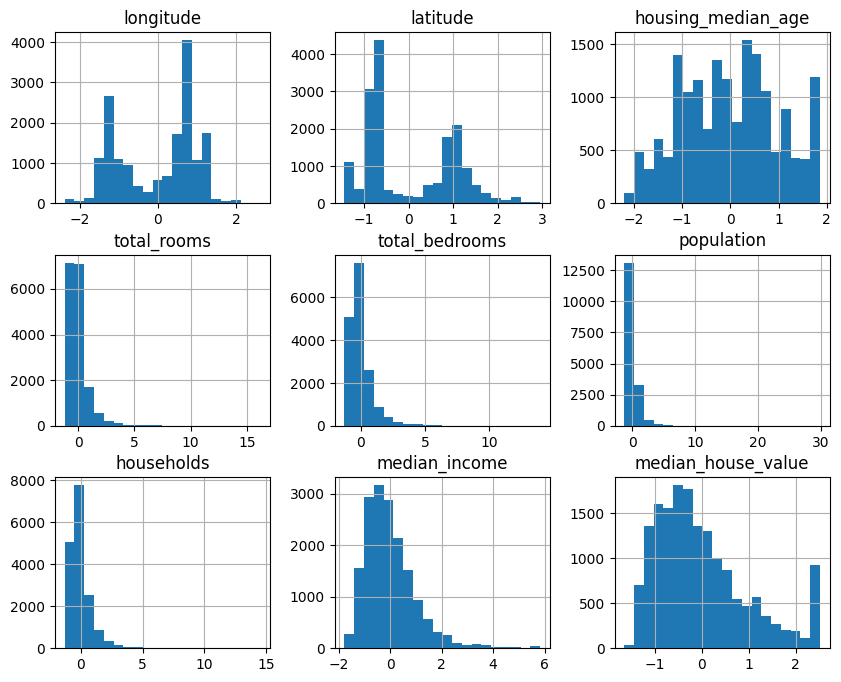

In [5]:
train_df_norm.hist(bins=20, figsize=(10, 8))

#### Create a binary label

In [6]:
threshold = 265000
train_df_norm['median_house_value_is_hight'] = (train_df['median_house_value'] > threshold).astype(int)
test_df_norm['median_house_value_is_hight'] = (test_df['median_house_value'] > threshold).astype(int)

train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_hight
3021,0.878784,-0.737002,-1.874114,0.868065,1.515042,0.919478,1.060484,0.119603,-0.701830,0
15131,-1.345470,1.036230,1.859916,-0.776929,-0.800501,-0.838586,-0.788571,0.042304,-0.159513,0
13456,-1.190870,0.802294,-0.285165,1.189174,1.851934,0.957811,1.851078,-0.373857,0.420741,0
8759,0.479815,-0.727645,-1.000192,-1.066386,-1.139766,-1.115625,-1.137057,0.388554,1.948541,1
397,1.307676,-1.312484,0.509310,-0.415911,-0.603585,-0.525829,-0.538910,-0.336701,-0.414721,0


In [14]:
# investigate the distribution of the label
train_df_norm['median_house_value_is_hight'].value_counts()
# => negative class is dominant

0    12753
1     4247
Name: median_house_value_is_hight, dtype: int64

#### Define model building & training Functions

In [7]:
# select features
inputs = {
    'median_income': tf.keras.Input(shape=(1,)),
    'total_rooms': tf.keras.Input(shape=(1,))
}

def create_model(my_inputs, my_learning_rate, METRICS):
  concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
  dense = layers.Dense(units=1, name='dense_layer', activation=tf.sigmoid)
  dense_output = dense(concatenated_inputs)
  """Create and compile a simple classification model."""
  my_outputs = {
    'dense': dense_output,
  }
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
  return model

def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
  features = {name:np.array(value) for name, value in dataset.items()} # map all feature_name -> feature_value list
  label = np.array(features.pop(label_name)) # label list

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where each array contains the data for one feature.  
  # Here, we're passing every column in the dataset. Note that the feature_layer will filter away most of those columns, 
  # leaving only the desired columns and their representations as features.
  history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=shuffle)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist

print("Defined the create_model and train_model functions.")


Defined the create_model and train_model functions.


#### Define plot function

In [8]:
def plot_curves(epochs, train_history, metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in metrics:
        metric_values = train_history[m]
        plt.plot(epochs[1:], metric_values[1:], label=m)
    plt.legend()

#### Train

Epoch 1/20


/home/tu/.local/lib/python3.8/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 1s 4ms/step - loss: 0.7240 - accuracy: 0.2474
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.6347 - accuracy: 0.2535
Epoch 3/20
170/170 [==============================] - 1s 5ms/step - loss: 0.5672 - accuracy: 0.3842
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 0.5168 - accuracy: 0.6830
Epoch 5/20
170/170 [==============================] - 1s 5ms/step - loss: 0.4794 - accuracy: 0.7635
Epoch 6/20
170/170 [==============================] - 1s 5ms/step - loss: 0.4520 - accuracy: 0.7918
Epoch 7/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4325 - accuracy: 0.8033
Epoch 8/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4191 - accuracy: 0.8093
Epoch 9/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4101 - accuracy: 0.8105
Epoch 10/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4044 - accuracy: 0.8109
Epoch 11/2

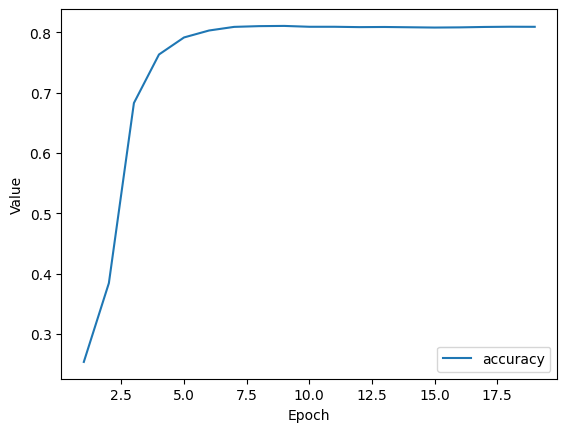

In [19]:
learning_rate = 0.001
epochs = 20
batch_size = 100

label_name = 'median_house_value_is_hight'
classification_threshold = 0.35

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    # tf.keras.metrics.Precision(name='precision', thresholds=classification_threshold),
    # tf.keras.metrics.Recall(name='recall', thresholds=classification_threshold)
]

model = create_model(inputs, learning_rate, METRICS)

epochs, train_hist = train_model(model, train_df_norm, epochs, label_name, batch_size)

plot_metrics = ['accuracy']
plot_curves(epochs, train_hist, plot_metrics)

#### Test the model

In [11]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

model.evaluate(x=features, y=label, batch_size=batch_size)

30/30 [==============================] - 0s 2ms/step - loss: 0.4070 - accuracy: 0.8047


/home/tu/.local/lib/python3.8/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[0.40696629881858826, 0.8046666383743286]

#### Add Precision & Recall metrics

Epoch 1/20


/home/tu/.local/lib/python3.8/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 1s 1ms/step - loss: 0.7124 - accuracy: 0.2555 - precision: 0.2359 - recall: 0.8846
Epoch 2/20
170/170 [==============================] - 0s 1ms/step - loss: 0.6345 - accuracy: 0.3571 - precision: 0.2712 - recall: 0.9327
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5708 - accuracy: 0.5548 - precision: 0.3475 - recall: 0.8912
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5200 - accuracy: 0.6924 - precision: 0.4362 - recall: 0.7900
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4812 - accuracy: 0.7602 - precision: 0.5147 - recall: 0.7045
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.7874 - precision: 0.5647 - recall: 0.6496
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.8028 - precision: 0.6023 - recall: 0.6202
Epoch 8/20
170/170 [==============================] 

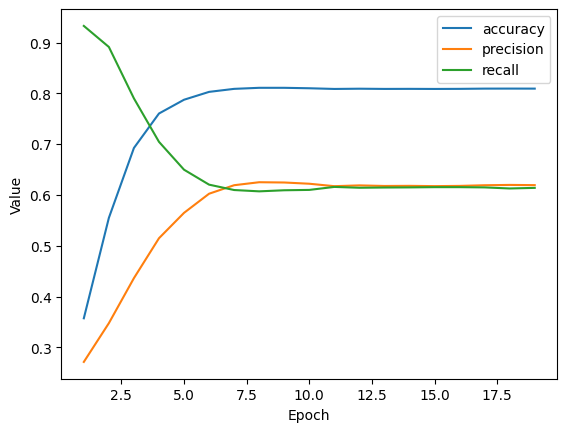

In [23]:
learning_rate = 0.001
epochs = 20
batch_size = 100

label_name = 'median_house_value_is_hight'
classification_threshold = 0.35

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(name='precision', thresholds=classification_threshold),
    tf.keras.metrics.Recall(name='recall', thresholds=classification_threshold)
]

model = create_model(inputs, learning_rate, METRICS)
epochs, train_hist = train_model(model, train_df_norm, epochs, label_name, batch_size)
plot_metrics = ['accuracy', 'precision', 'recall']
plot_curves(epochs, train_hist, plot_metrics)


#### Try AUC metric - as 'summary' metric for classification models

Epoch 1/20


/home/tu/.local/lib/python3.8/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 1s 3ms/step - loss: 0.9614 - auc: 0.2388
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.8338 - auc: 0.2540
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7248 - auc: 0.2859
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6354 - auc: 0.3920
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5645 - auc: 0.6346
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5122 - auc: 0.7881
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4752 - auc: 0.8325
Epoch 8/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4503 - auc: 0.8351
Epoch 9/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4331 - auc: 0.8355
Epoch 10/20
170/170 [==============================] - 0s 3ms/step - loss: 0.4208 - auc: 0.8354
Epoch 11/20
170/170 [==============================] - 0s 3m

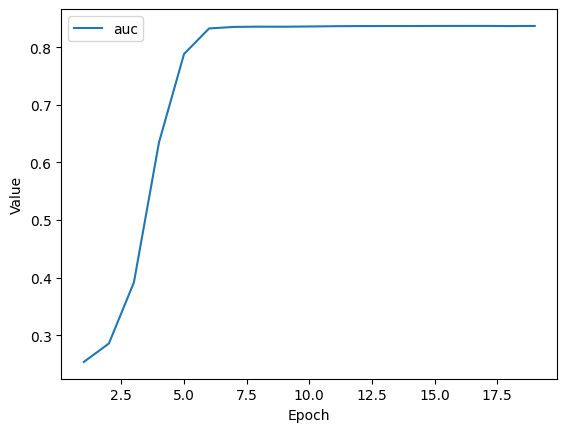

In [28]:
learning_rate = 0.001
epochs = 20
batch_size = 100

label_name = 'median_house_value_is_hight'
classification_threshold = 0.35

METRICS = [
    tf.keras.metrics.AUC(name='auc', num_thresholds=100)
]

model = create_model(inputs, learning_rate, METRICS)
epochs, train_hist = train_model(model, train_df_norm, epochs, label_name, batch_size)
plot_metrics = ['auc']
plot_curves(epochs, train_hist, plot_metrics)
